# Luminex Automation

In [545]:
# Setting up varriables
directory_path_name = #put file path where you want outputs to go 
data_file_path = #put data file path 
metadata_file_path = #put path to metadata here 

DataStart = #First row of data (after blanks and standards)
Total = #Total number of samples


SyntaxError: invalid syntax (3215980712.py, line 2)

In [538]:
# for importing needed packages 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

In [500]:
# Import raw data seperated into individual spreadsheets for each analytes
raw_data = pd.read_excel(data_file_path, sheet_name = None, header = 10, usecols = 'A:L', nrows = 49)

# Import metadata with sample numbers corresponding to raw data
metadata = pd.read_excel(metadata_file_path, header = 2, usecols = 'A:K')

# Analytes
analytes = raw_data.keys()

In [502]:
# Function to input the upper and lower limits of the assay into values above or below the limit of detection
# @para:
    #conc - the observed concentration
    #range_value - the designation if it is above or below the limit of detection
    #limitsOfDetection - list of the limits of detection for each analyte
    #key - analyte of intrest 
# returns a concentration value
def replace_limits(conc, range_value, limitsOfDetection, key):
    if range_value == "OOR <":
        return limitsOfDetection.loc[key].iloc[1]
    elif range_value == "OOR >":
        return limitsOfDetection.loc[key].iloc[0]
    else:
        return conc

In [ ]:
def extract_limits(key):
    upperLimitsOfDetection = [key]
    lowerLimitsOfDetection = [key]
    for plate in raw_data.keys():
        standards = raw_data[plate][key]["Conc in Range"][1:8].dropna() #selects out the standard values from spreadsheet
        standards2 = [num for num in standards if isinstance(num,(float))] #selects the standard values that are in the detectable range of the assay
        upperLimitsOfDetection.append(max(standards2)) #Adds it to the limitsOfDetection list
        lowerLimitsOfDetection.append(min(standards2))
    upper.append(upperLimitsOfDetection)
    lower.append(lowerLimitsOfDetection)

In [504]:
red = [] 
orange = []
yellow = []
green = []

def QC_analyte(key):
    #Totals the number of OOR < and OOR > in Obs Conc 
    ObsConcCounts = raw_data[key].iloc[DataStart:]["Obs Conc"].value_counts().reindex(['OOR <', 'OOR >'], fill_value=0)

    #Totals the number of OOR < and OOR > in Conc in Range 
    ConcInRangeCounts = raw_data[key].iloc[DataStart:]["Conc in Range"].value_counts().reindex(['OOR <', 'OOR >'], fill_value=0)

    #Determines how many of the Obs Conc values are actually within the LOD
    ObsConcRealNum = sum(isinstance(x, str) for x in raw_data[key].iloc[DataStart:]["Obs Conc"])

    # If 95% of the observed concentration are above or below the LOD, they are determined to be unusable analytes
    if ObsConcCounts[0]/Total > 0.95 or ObsConcCounts[1]/Total > 0.95:
        red.append(key)
        return "red"
    # If 80% of the concentrations are in range, meaning they are a starred or unstarred value, they are usable
    elif ConcInRangeCounts[0]/Total < 0.80 and ConcInRangeCounts[1]/Total < 0.80:
        green.append(key)
        return "green"
    # If at least one value in the observed concentration is a unstarred value, it is potentially usable
    elif ObsConcRealNum/Total < 0.9:
        yellow.append(key)
        return "yellow"
    # Everything else is put in the category of slightly un-usable 
    else: 
        orange.append(key)
        return "orange"

In [506]:
limitsOfDetection = [] #Place for the limits of detection for each analyte

for key in analytes:

    standards = raw_data[key]["Conc in Range"][1:8] #selects out the standard values from spreadsheet
    
    standards2 = [num for num in standards if isinstance(num,(float))] #selects the standard values that are in the detectable range of the assay
    list = [key, max(standards2), min(standards2)] #selects the analyte name, OOR > and OOR < 
    limitsOfDetection.append(list) #Adds it to the limitsOfDetection list

limitsOfDetection = pd.DataFrame(limitsOfDetection, columns = ['key', 'OOR >', 'ORR <']) #Makes a dataframe for the limits of detection
limitsOfDetection = limitsOfDetection.set_index('key') #Sets the row names to be the analyte name

In [508]:
limitsOfDetection.to_csv(directory_path_name + "LimitOfDetection.csv") #Exports the LOD for each analyte

Here you can go to the file you just created and check the limits of detection against the detection limits provided by 
the kit. To change any of these values, you can open up the file in excel, change the value and save it back to LimitOfDetection.csv

In [511]:
#Loads in limit of detection with potential edits
limitsOfDetection = pd.read_csv(directory_path_name + "LimitOfDetection.csv", index_col = "key")

In [515]:
for key in analytes:   

    #Sort analytes into green, yellow, orange and red categories
    classification = QC_analyte(key) 

    #Uses the limits of detection values to replace any starred values or anything OOR > or ORR <
    raw_data[key]["Obs Conc"] = raw_data[key].apply(
        lambda row: replace_limits(row["Obs Conc"], row["Conc in Range"], limitsOfDetection, key), axis=1
    )

    #Combines the metadata with the analyte concentration values
    metadata.insert(len(metadata.columns), key, raw_data[key]["Obs Conc"][8:].tolist())

metadata.to_excel(directory_path_name + "cleaned_data.xlsx")

In [ ]:
QC_analytes = metadata.drop(labels = red + orange, axis = 1)

baseline = metadata[:6][raw_data.keys()].mean()
baseline.to_csv(directory_path_name + "baseline.csv")


for key in green or yellow:
    QC_analytes[key] = np.log2(QC_analytes[key] / baseline[key])


QC_analytes.to_excel(directory_path_name + "log_transformed.xlsx")

In [517]:
with PdfPages(directory_path_name + 'green_plots.pdf') as pdf:
    for key in green:
        for ID in metadata['UW AID'].unique():
            data = pd.DataFrame(metadata[['UW AID', 'Day', key]].loc[metadata['UW AID'] == ID])
            plt.plot(data['Day'], data[key], marker='o', color = "black")
        
        ax = plt.gca()
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        #plt.legend(metadata['UW AID'].unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(key)
        plt.axhline(y = limitsOfDetection.loc[key].iloc[1], color = 'grey', linestyle = 'dashed') 
        pdf.savefig()  # Save the current figure to the PDF
        plt.close()  # Close the figure to avoid memory issues

    key = plt.figure()

<Figure size 640x480 with 0 Axes>

In [518]:
with PdfPages(directory_path_name + 'yellow_plots.pdf') as pdf:
    for key in yellow:
        for ID in metadata['UW AID'].unique():
            data = pd.DataFrame(metadata[['UW AID', 'Day', key]].loc[metadata['UW AID'] == ID])
            plt.plot(data['Day'], data[key], marker='o', color = "black")
        
        ax = plt.gca()
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        #plt.legend(metadata['UW AID'].unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.axhline(y = limitsOfDetection.loc[key].iloc[1], color = 'grey', linestyle = 'dashed') 
        plt.title(key)
        pdf.savefig()  # Save the current figure to the PDF
        plt.close()  # Close the figure to avoid memory issues

    key = plt.figure()

<Figure size 640x480 with 0 Axes>

Day -7


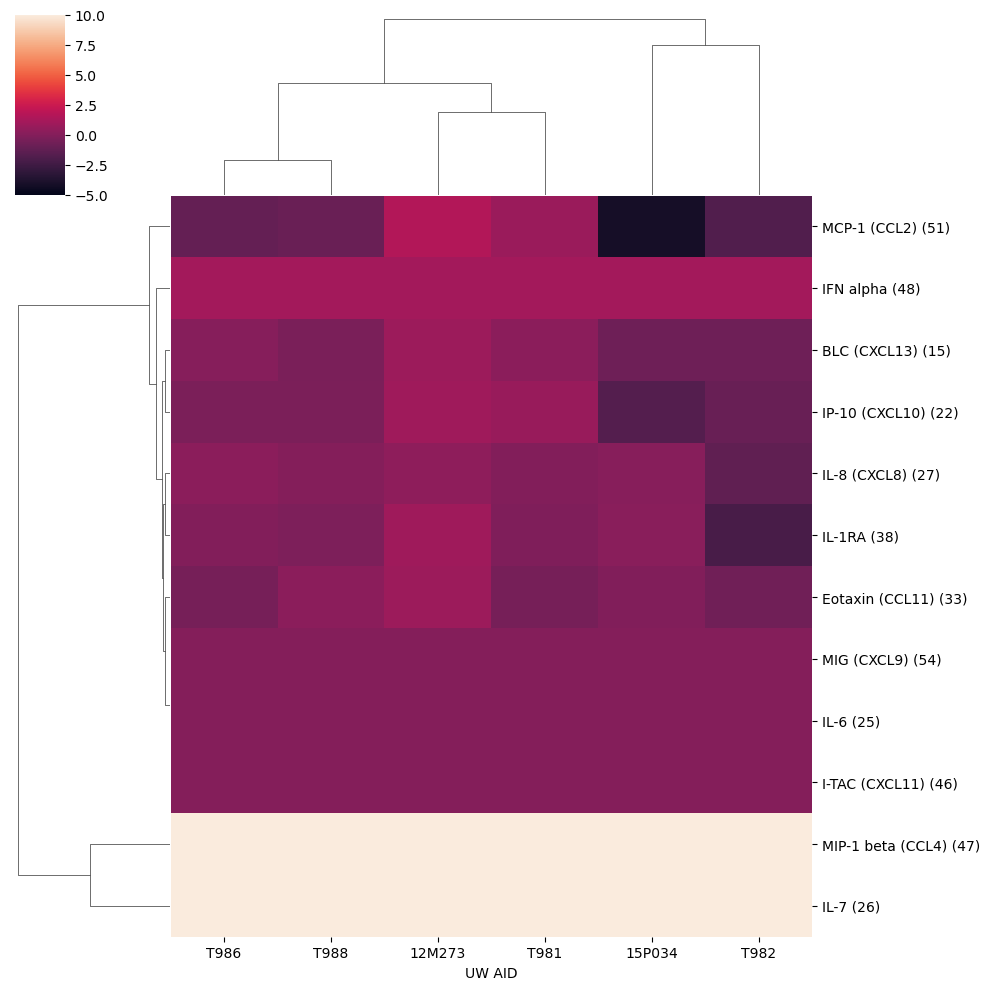

Day 3


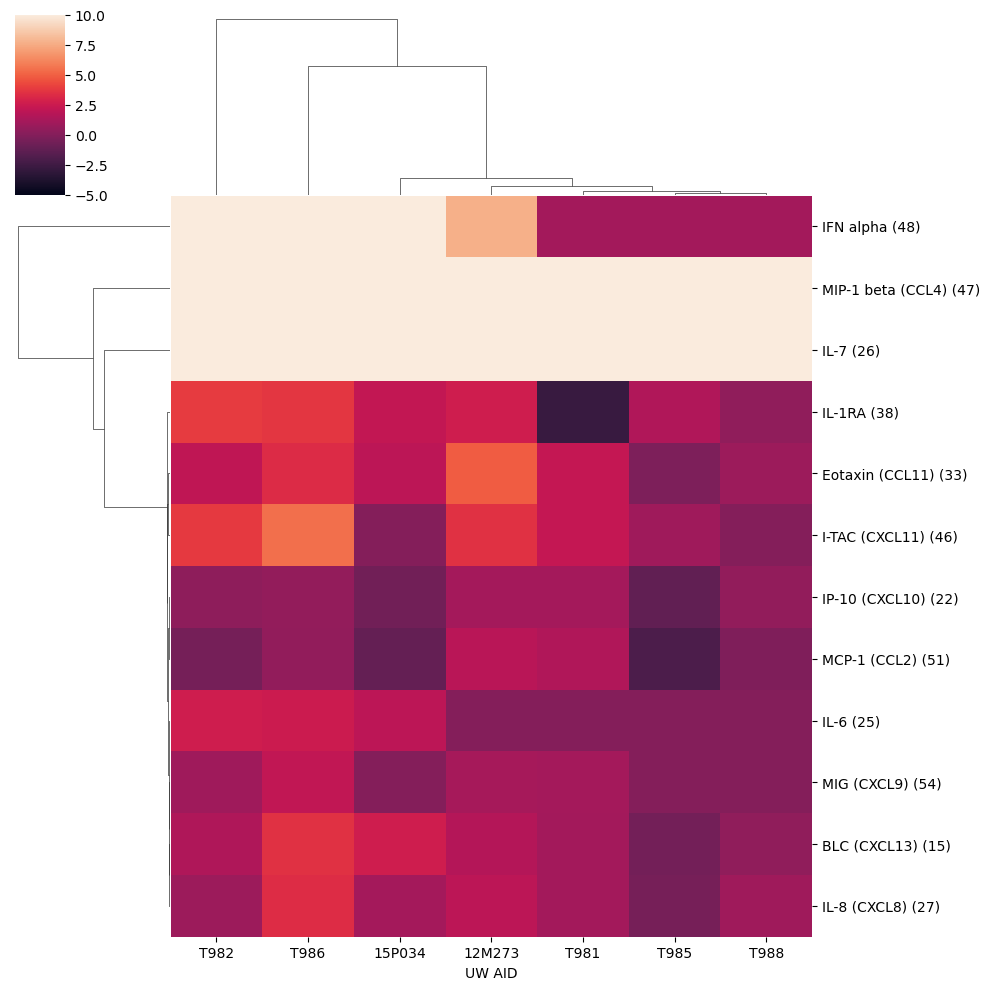

Day 5


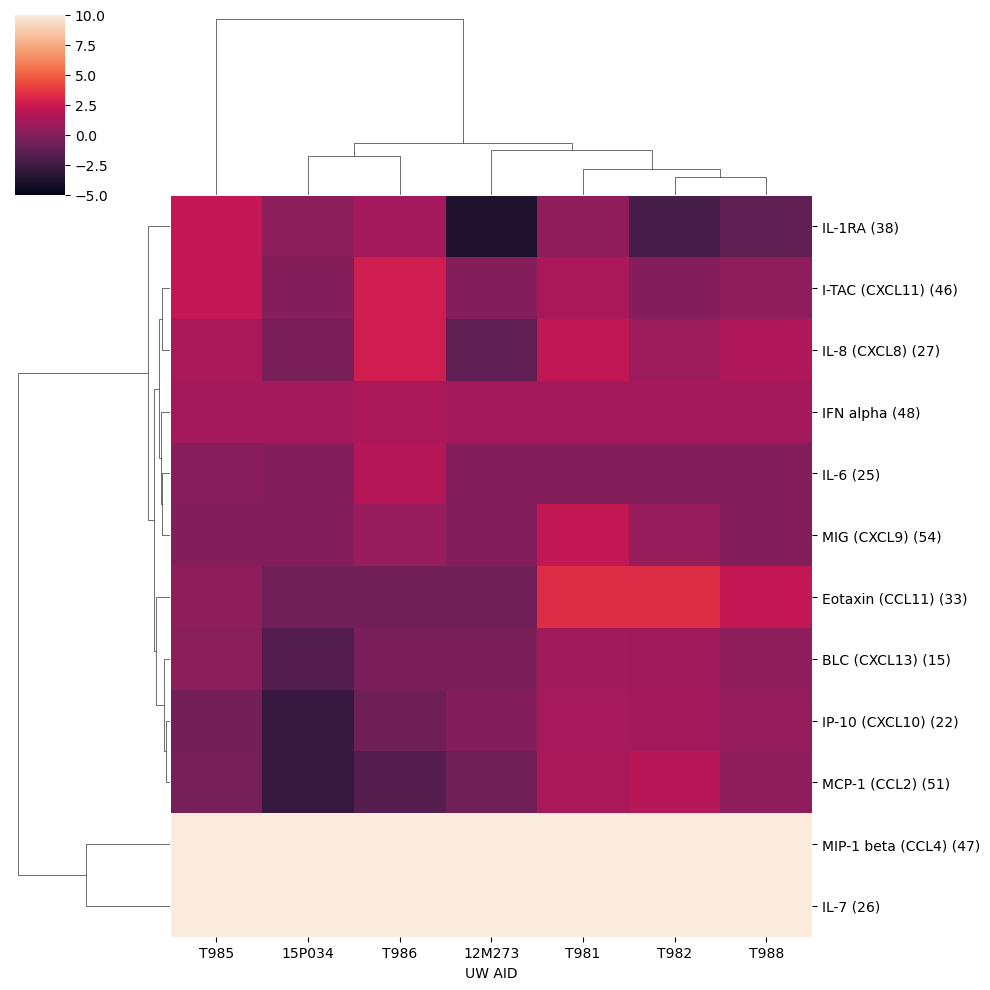

Day 7


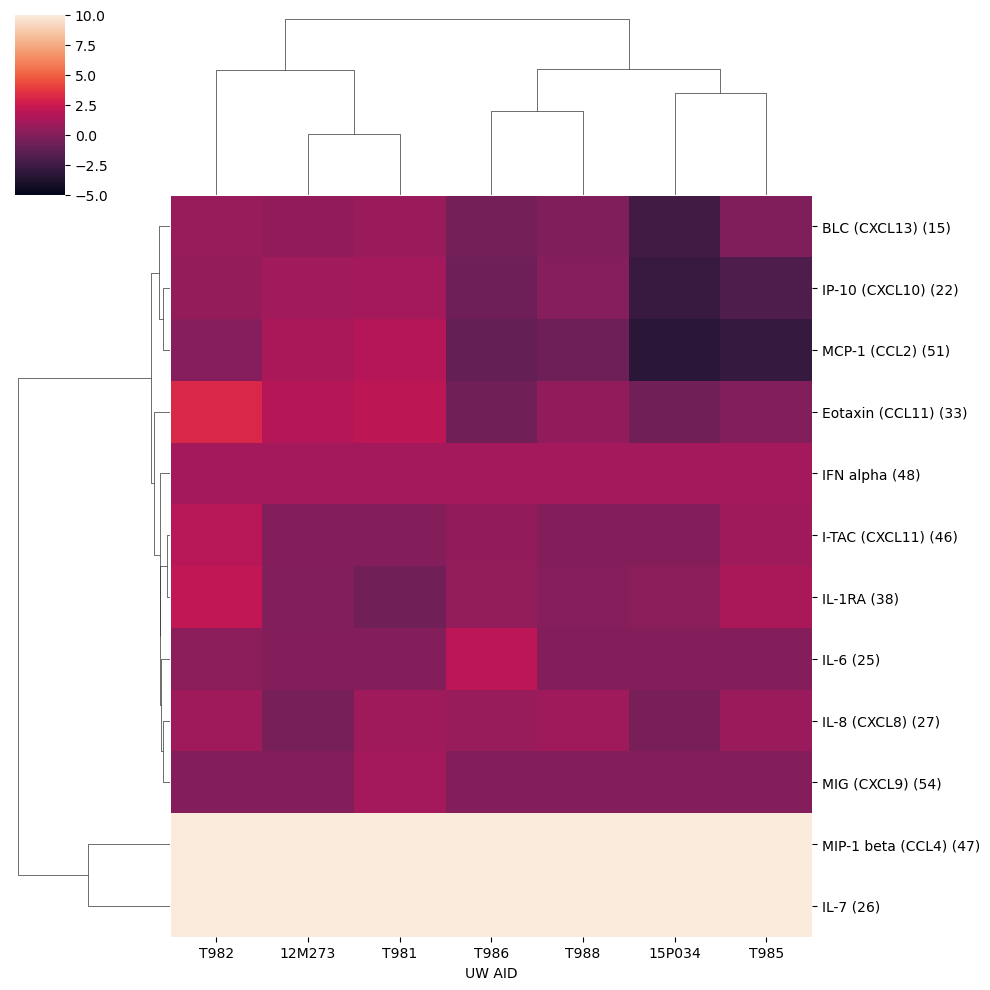

Day 10


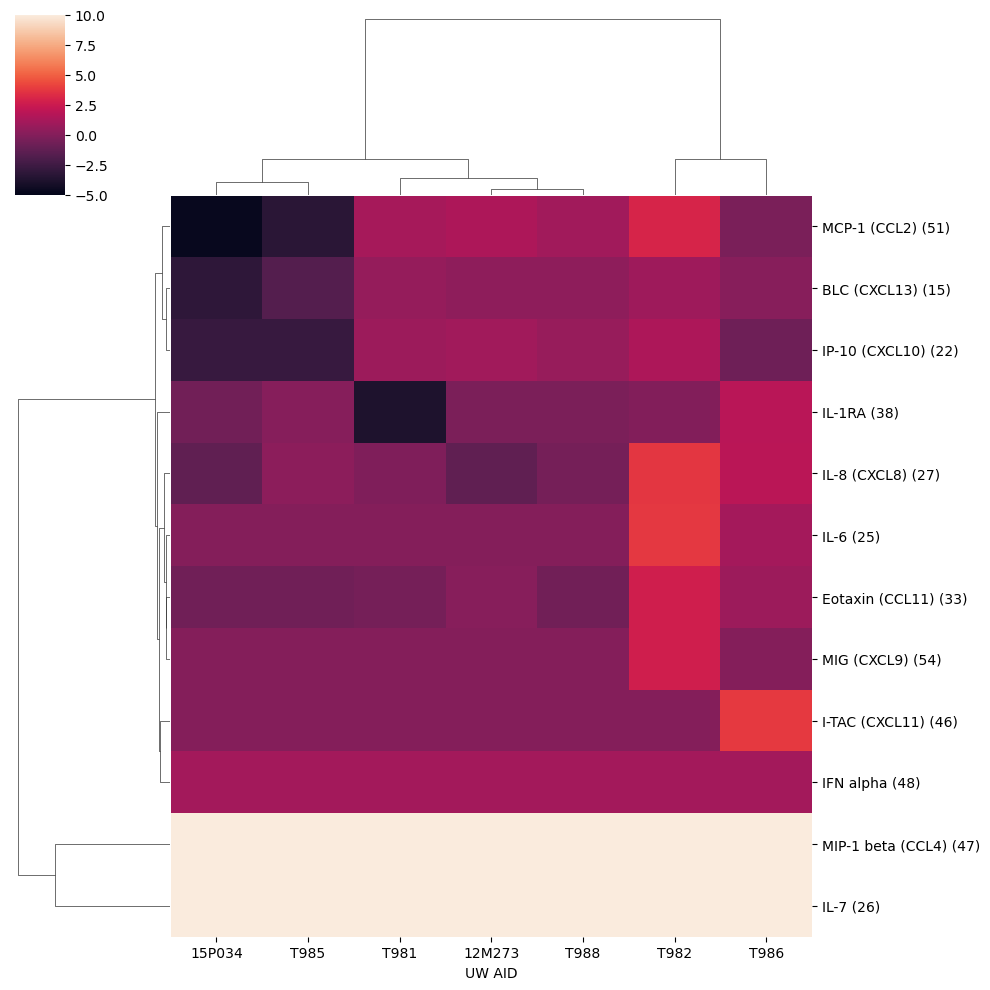

Day 14


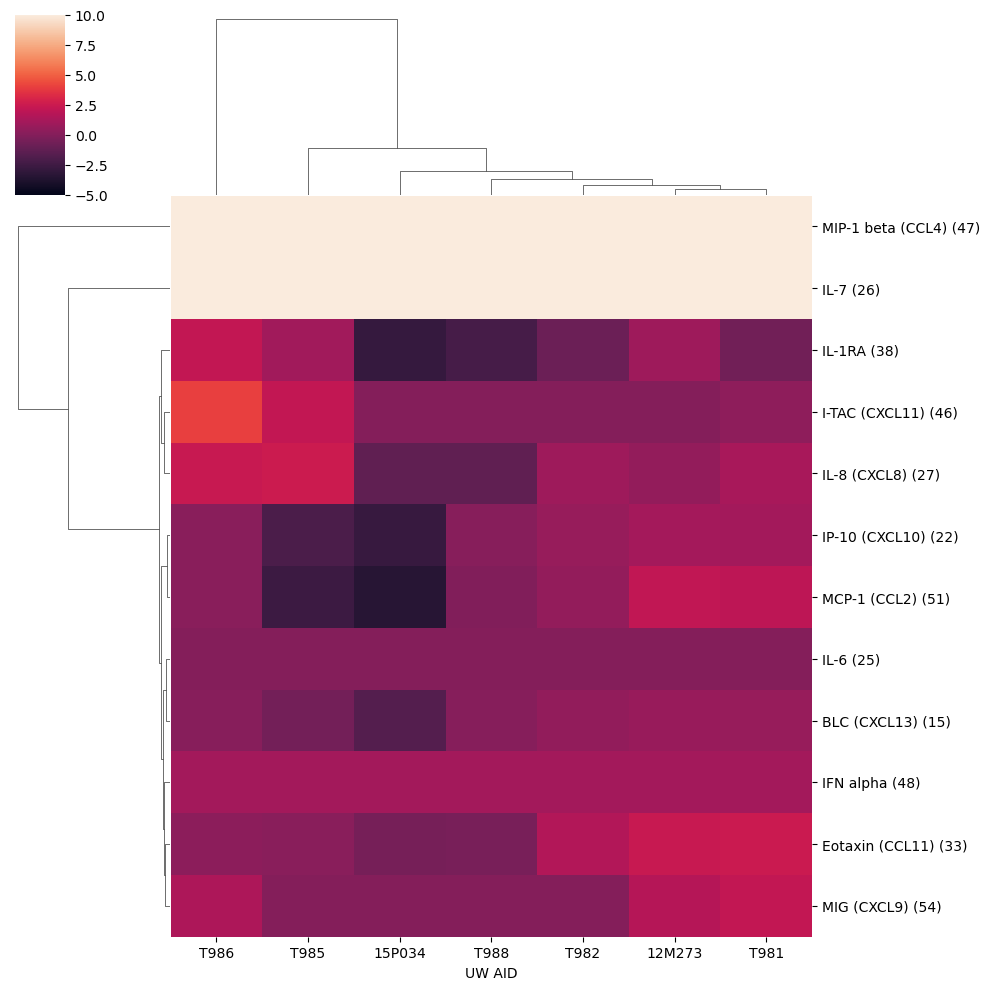

In [536]:
for day in metadata['Day'].unique():
    day_subset = QC_analytes[QC_analytes["Day"] == day]
    forHeatmap = pd.concat((day_subset[["UW AID"]],day_subset[green],day_subset[yellow]), axis = 1).set_index("UW AID").T
    sns.clustermap(forHeatmap, vmin = -5, vmax = 10)
    print(day)
    plt.show()
